In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

In [1]:
# Unzipping a file in Google Colab
from zipfile import ZipFile
import os

# Path to the zip file
zip_path = '/content/shanghai-22.zip'  # Change this to the path of your .zip file

# Destination directory
extract_dir = '/content'  # Change this if you want a different extraction folder

# Create directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Files extracted to: {extract_dir}")


Files extracted to: /content


In [3]:
def display_matches_knn(img1, img2):
    # Convert images to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Find keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)

    # Match features using KNN
    bf = cv2.BFMatcher()
    raw_matches = bf.knnMatch(des1, des2, k=2)

    # Apply Lowe's ratio test
    good_matches = []
    draw_matches = []  # Separate list for drawing
    for m, n in raw_matches:
        if m.distance < 0.23 * n.distance:
            good_matches.append(m)  # Store single DMatch object for stitching
            draw_matches.append([m])  # Store in list for drawing

    # Draw matches using drawMatchesKnn
    matched_img = cv2.drawMatchesKnn(img1, kp1,
                                    img2, kp2,
                                    draw_matches,
                                    None,
                                    flags=2)

    # Display results
    plt.figure(figsize=(20,10))
    plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
    plt.title(f'Found {len(good_matches)} matching points using KNN')
    plt.axis('off')
    plt.show()

    return good_matches, kp1, kp2

In [4]:
# Adjust contrast of both images before processing
def adjust_contrast(img, clip_limit=2.0, tile_grid_size=(8, 8)):
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        cl = clahe.apply(l)
        limg = cv2.merge((cl, a, b))
        return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

In [15]:
# Load images
img1 = cv2.imread('/content/pano_image1.jpg')
img2 = cv2.imread('/content/pano_image2.jpg')

# Apply contrast adjustment
img1_adjusted = adjust_contrast(img1)
img2_adjusted = adjust_contrast(img2)

if img1 is None or img2 is None:
    print("Error: Could not load images")

In [7]:
def compute_homography(src_pts, dst_pts):
    """Compute homography matrix using DLT"""
    if len(src_pts) < 4:
        raise ValueError("At least 4 point correspondences are required")

    # Construct the A matrix for Ah = 0
    A = []
    for (x1, y1), (x2, y2) in zip(src_pts, dst_pts):
        A.append([-x1, -y1, -1, 0, 0, 0, x1*x2, y1*x2, x2])
        A.append([0, 0, 0, -x1, -y1, -1, x1*y2, y1*y2, y2])

    A = np.array(A)

    # Solve using SVD
    _, _, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape(3, 3)

    # Normalize
    H = H / H[2, 2]
    return H

In [ ]:
# def forward_warp(img, H, output_size):
#     """Forward warping"""
#     height, width = output_size
#     warped = np.zeros((height, width, 3), dtype=np.uint8)

#     y_coords, x_coords = np.indices((img.shape[0], img.shape[1]))
#     coords = np.stack([x_coords.ravel(), y_coords.ravel(), np.ones_like(x_coords).ravel()])

#     # Transform coordinates
#     transformed = H @ coords
#     transformed /= transformed[2]

#     x_transformed = transformed[0].astype(int)
#     y_transformed = transformed[1].astype(int)

#     # Filter valid coordinates
#     valid_indices = (x_transformed >= 0) & (x_transformed < width) & \
#                    (y_transformed >= 0) & (y_transformed < height)

#     x_transformed = x_transformed[valid_indices]
#     y_transformed = y_transformed[valid_indices]

#     warped[y_transformed, x_transformed] = img[y_coords.ravel()[valid_indices],
#                                              x_coords.ravel()[valid_indices]]
#     return warped

In [8]:
def bilinear_interpolate(img, x, y):
    """Perform bilinear interpolation for given coordinates (x, y) in the input image."""
    h, w = img.shape[:2]

    # Get integer coordinates of the top-left pixel
    x0 = int(np.floor(x))
    y0 = int(np.floor(y))

    # Get integer coordinates of the bottom-right pixel
    x1 = x0 + 1
    y1 = y0 + 1

    # Check boundaries
    if x0 < 0 or x1 >= w or y0 < 0 or y1 >= h:
        return 0  # Return default value for out-of-bounds

    # Get pixel values at the four corners
    Q11 = img[y0, x0] if 0 <= y0 < h and 0 <= x0 < w else 0
    Q21 = img[y0, x1] if 0 <= y0 < h and 0 <= x1 < w else 0
    Q12 = img[y1, x0] if 0 <= y1 < h and 0 <= x0 < w else 0
    Q22 = img[y1, x1] if 0 <= y1 < h and 0 <= x1 < w else 0

    # Calculate the weights
    dx = x - x0
    dy = y - y0
    weight_Q11 = (1 - dx) * (1 - dy)
    weight_Q21 = dx * (1 - dy)
    weight_Q12 = (1 - dx) * dy
    weight_Q22 = dx * dy

    # Compute the interpolated pixel value
    value = (
        Q11 * weight_Q11 +
        Q21 * weight_Q21 +
        Q12 * weight_Q12 +
        Q22 * weight_Q22
    )

    return value

In [9]:
def inverse_warp(img, H, output_size):
    """Inverse warping using manual bilinear interpolation."""
    height, width = output_size
    H_inv = np.linalg.inv(H)

    # Create an empty output image
    warped = np.zeros((height, width, img.shape[2]), dtype=img.dtype) if len(img.shape) == 3 else np.zeros((height, width), dtype=img.dtype)

    # Loop over each pixel in the output image
    for y in range(height):
        for x in range(width):
            # Transform the pixel location back to the input image using H_inv
            target_coords = np.array([x, y, 1])
            source_coords = H_inv @ target_coords
            source_coords /= source_coords[2]  # Normalize homogeneous coordinates

            src_x, src_y = source_coords[0], source_coords[1]

            # Perform bilinear interpolation for each color channel (if applicable)
            if len(img.shape) == 3:  # Color image
                for c in range(img.shape[2]):
                    warped[y, x, c] = bilinear_interpolate(img[:, :, c], src_x, src_y)
            else:  # Grayscale image
                warped[y, x] = bilinear_interpolate(img, src_x, src_y)

    return warped


In [10]:
def create_mosaic(img1, img2):
    """Create seamless mosaic from two images using custom warping"""
    # Get matches using existing display_matches_knn function
    good_matches, kp1, kp2 = display_matches_knn(img1, img2)

    if len(good_matches) < 4:
        raise ValueError("Not enough good matches found. Need at least 4 matches.")

    # Get matching points
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches])
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches])

    # Compute homography
    H= compute_homography(src_pts, dst_pts)

    # Calculate output dimensions
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    corners = np.float32([[0, 0, 1], [w1, 0, 1], [0, h1, 1], [w1, h1, 1]]).T
    transformed = H @ corners
    transformed /= transformed[2]

    min_x = min(0, transformed[0].min())
    max_x = max(w2, transformed[0].max())
    min_y = min(0, transformed[1].min())
    max_y = max(h2, transformed[1].max())

    # Adjust homography for offset
    offset_matrix = np.array([
        [1, 0, -min_x],
        [0, 1, -min_y],
        [0, 0, 1]
    ])
    H_adjusted = offset_matrix @ H

    # Create output canvas
    output_size = (int(max_y - min_y), int(max_x - min_x))

    result = inverse_warp(img1, H_adjusted, output_size)

    # Place second image
    y_offset = int(-min_y)
    x_offset = int(-min_x)
    y_end = min(y_offset + h2, result.shape[0])
    x_end = min(x_offset + w2, result.shape[1])
    result[y_offset:y_end, x_offset:x_end] = img2[:y_end-y_offset, :x_end-x_offset]

    return result.astype(np.uint8)

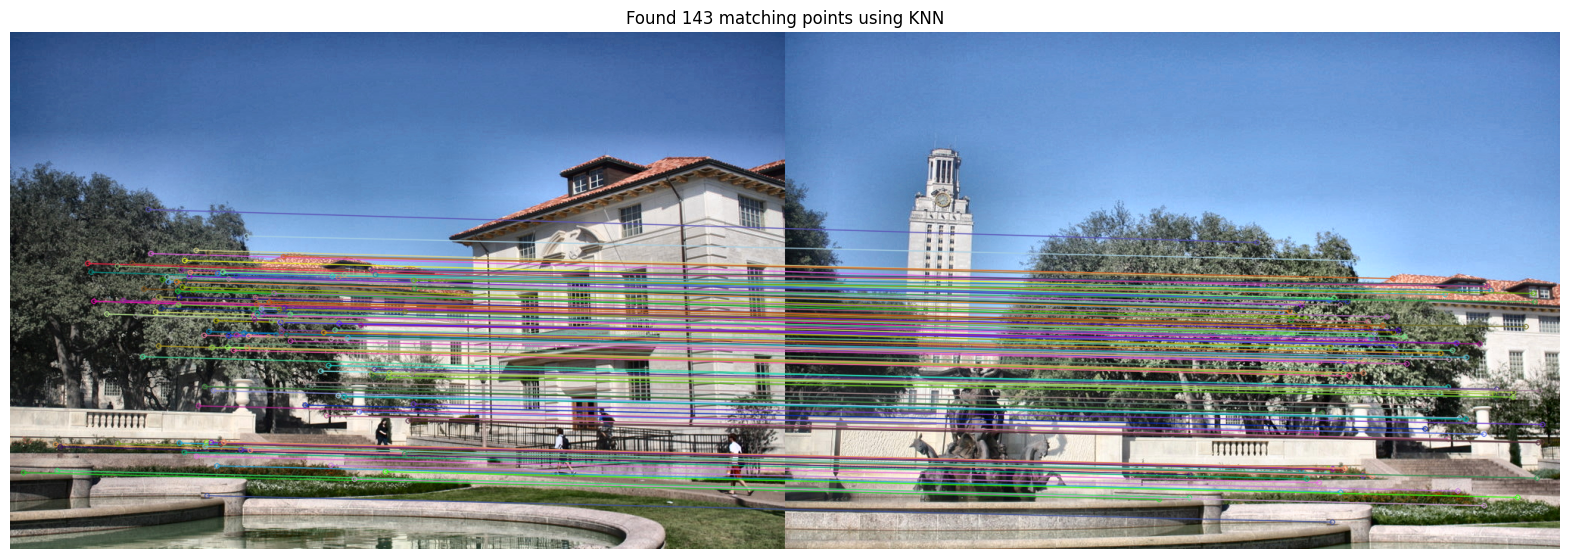

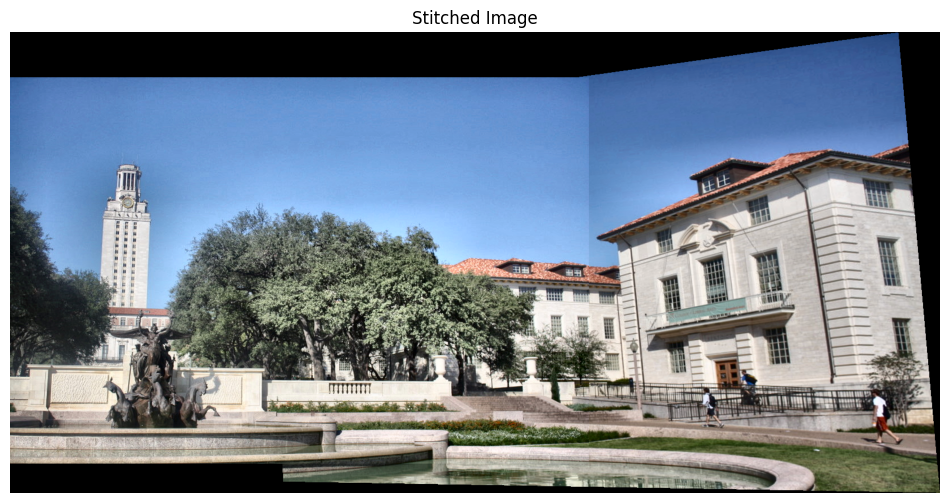

In [16]:
# Stitch images
result = create_mosaic(img1_adjusted, img2_adjusted)

# Display result
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
plt.title('Stitched Image')
plt.axis('off')
plt.show()

In [12]:
def stitch_three_images_random(img1, img2, img3):
    # Create list of images with their labels
    images = [(img1, 'Image 1'), (img2, 'Image 2'), (img3, 'Image 3')]
    random.shuffle(images)

    print(f"\n=== Stitching Sequence ===")
    print(f"First stitch: {images[0][1]} with {images[1][1]}")
    # First stitch: combine first two images
    result_first = create_mosaic(images[0][0], images[1][0])
        # Display result
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(result_first, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
    plt.title('Stitched Image')
    plt.axis('off')
    plt.show()
    print(f"Second stitch: Result of ({images[0][1]} + {images[1][1]}) with {images[2][1]}")
    # Second stitch: combine previous result with third image
    final_result = create_mosaic(result_first, images[2][0])
    # Display result
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(final_result, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
    plt.title('Stitched Image')
    plt.axis('off')
    plt.show()
    return final_result

Starting random stitching process...

=== Stitching Sequence ===
First stitch: Image 3 with Image 2


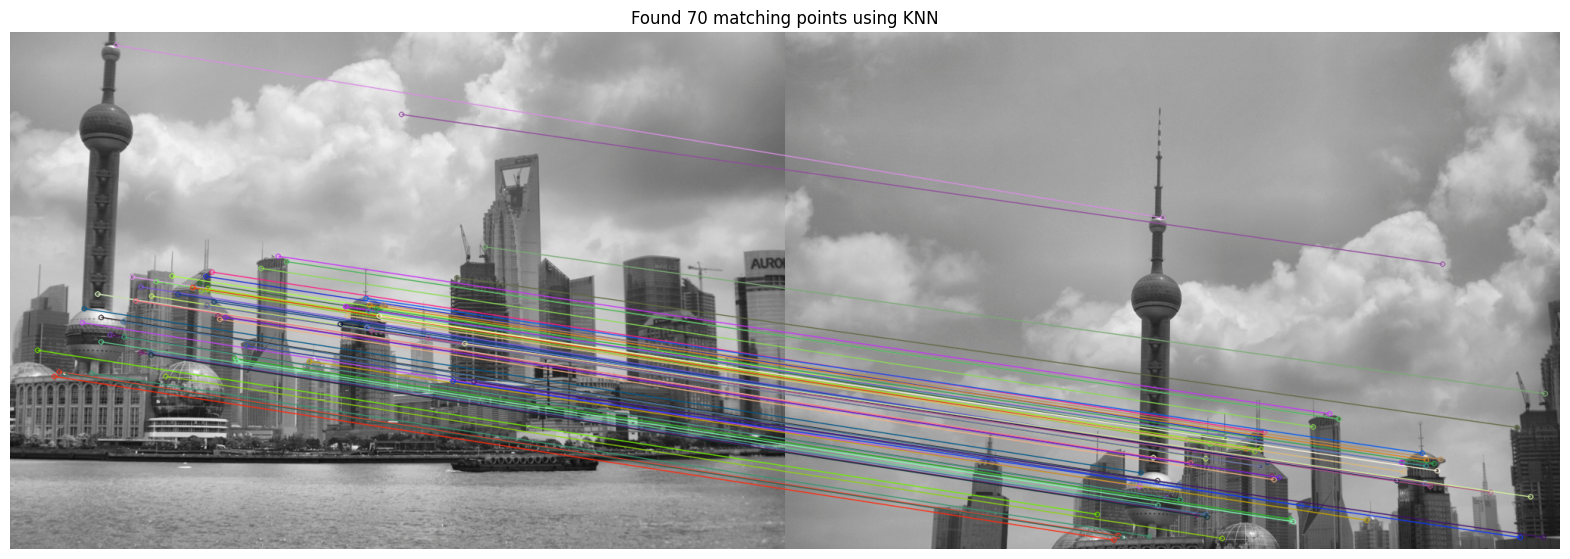

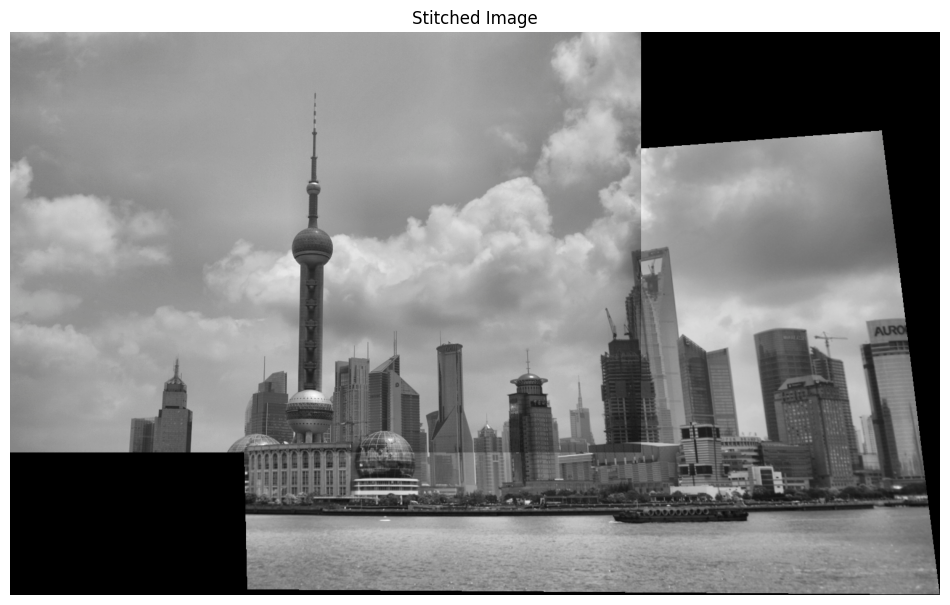

Second stitch: Result of (Image 3 + Image 2) with Image 1


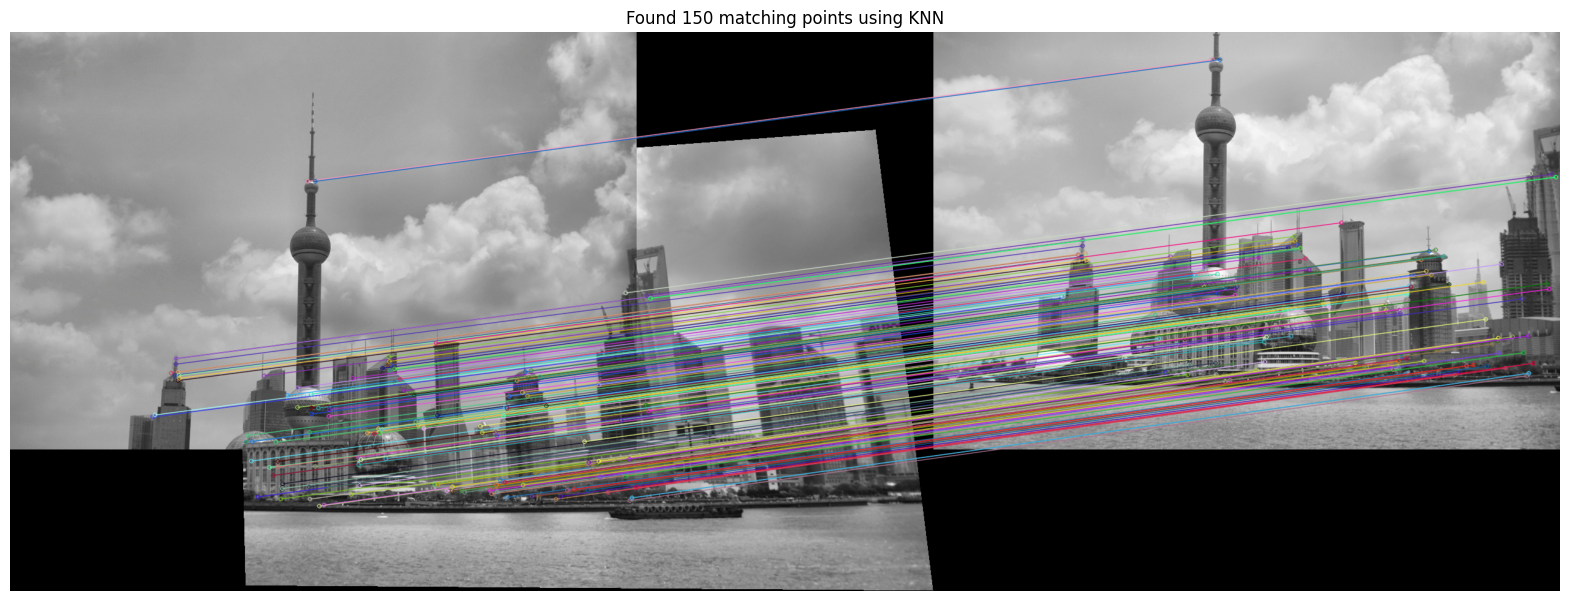

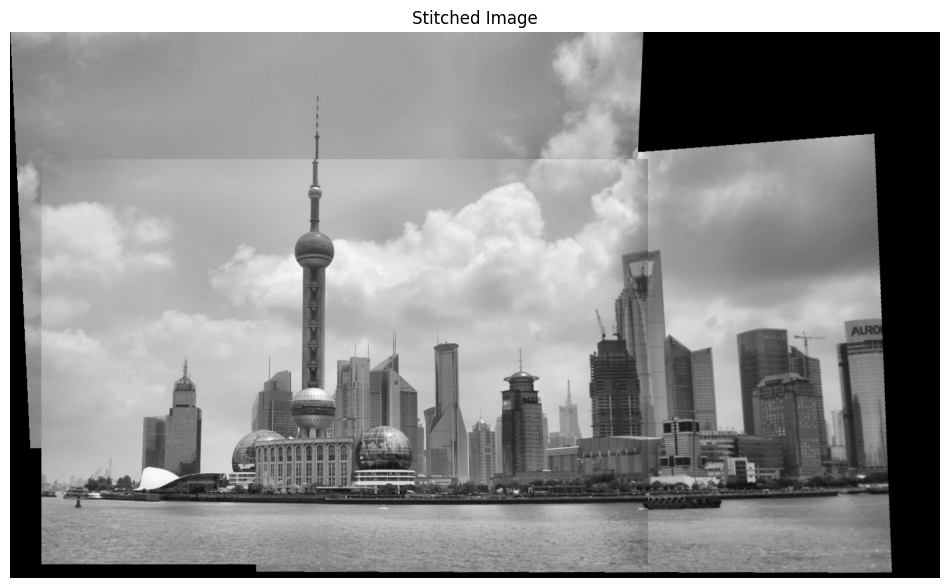

In [14]:
# Load three images
img1 = cv2.imread('/content/shanghai-21.png')
img2 = cv2.imread('/content/shanghai-22.png')
img3 = cv2.imread('/content/shanghai-23.png')

img1_adjusted=adjust_contrast(img1)
img2_adjusted=adjust_contrast(img2)
img3_adjusted=adjust_contrast(img3)

if img1 is None or img2 is None or img3 is None:
    print("Error: Could not load one or more images")

print("Starting random stitching process...")
try:
    # Perform random stitching of three images
    result = stitch_three_images_random(img1_adjusted, img2_adjusted, img3_adjusted)

except Exception as e:

    print(f"Error during stitching: {str(e)}")

In [22]:
# Load images
img1 = cv2.imread('/content/aaa.jpg')
img2 = cv2.imread('/content/aad.jpg')
# Apply contrast adjustment
img3_adjusted = adjust_contrast(img1)
img4_adjusted = adjust_contrast(img2)

if img1 is None or img2 is None:
    print("Error: Could not load images")

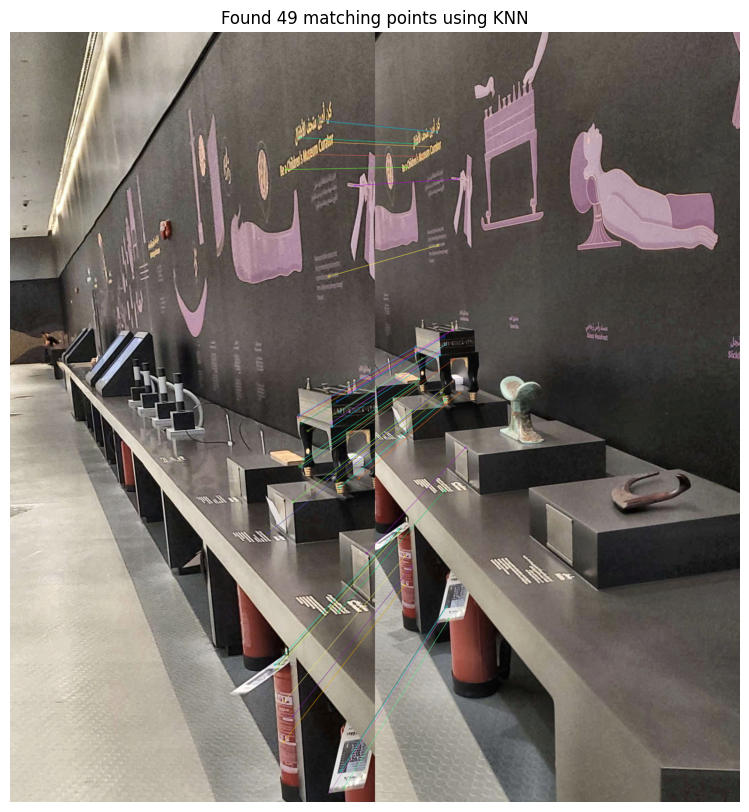

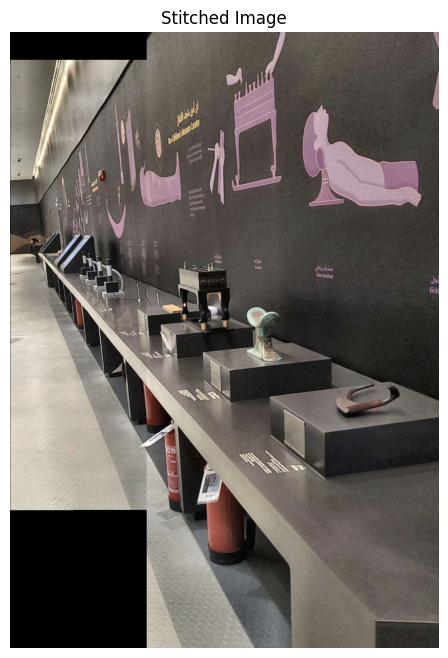

In [23]:
# Stitch images
result = create_mosaic(img3_adjusted, img4_adjusted)

# Display result
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
plt.title('Stitched Image')
plt.axis('off')
plt.show()